# Bouncing Balls, Beautiful Patterns
This notebook describes how to generate satisfying animations like those shown in the videos of the youtube playlist below.

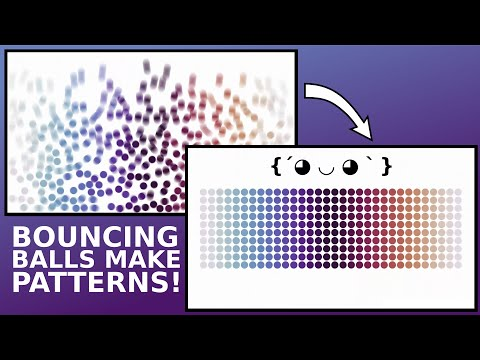

In [1]:
from IPython.display import YouTubeVideo, HTML
YouTubeVideo('nDhOGsBj1fA', listType="playlist", list="PL70Kxx3q2LQR8LEJVzP92HAQNupPKBlEX", width=600, height=338)

## Summary
The animations show bouncing balls obeying physical laws; for a fleeting moment, the balls pass through a beautiful regular arrangement.

Each animation is obtained by joining two simulations, both starting from the time in which the balls are arranged regularly ($t = 0$). One simulates forward in time (from $t = 0$ to $t = +2$), one backwards (from $t = 0$ to $t = -2$). The backward simulation is actually a standard simulation in which:
- the initial velocity of the balls is reversed
- the elasticity of all bodies in the simulation is the reciprocal of the true one; for example, if the elasticity is normally 0.9 (which implies that balls, as expected, lose energy at each bounce), during the "backwards" simulation the elasticity is set to $1 / 0.9$, which is above one: then, balls _gain_ energy at each bounce. 

When the backward simulation is played back in reverse, the balls follow the expected dynamics (they lose energy at each bounce), and their trajectories end at the regular arrangement defined for $t=0$.

To get the final trajectories, you join:
- the backwards simulation played back in reverse (which ends at the configuration defined for $t=0$); and
- the forward simulation (which starts at $t=0$).

The picture below illustrates the idea.
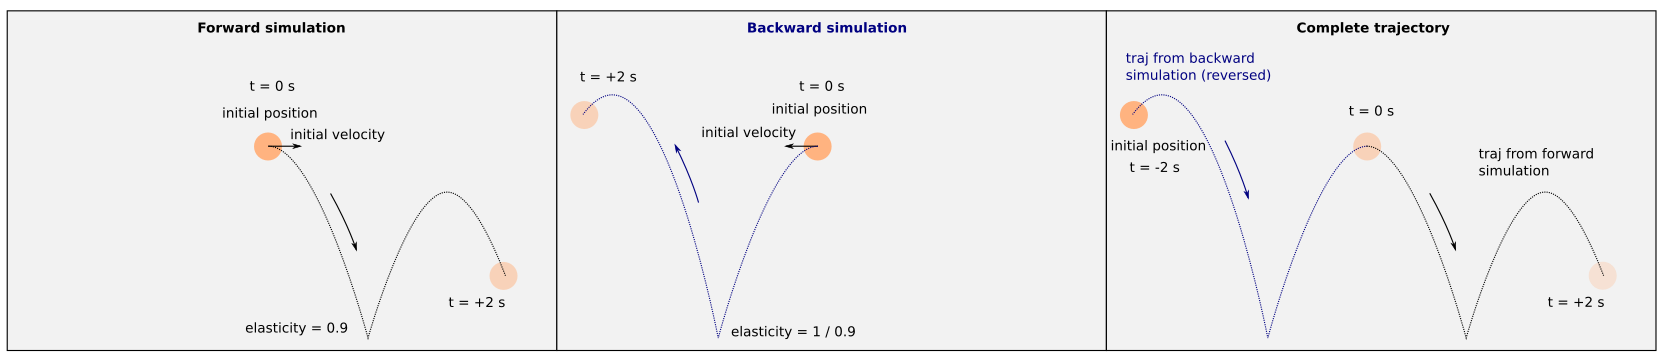


## Step 0: libraries and imports
We are going to use the [pymunk](http://www.pymunk.org/) library for running simulations, and then matplotlib for displaying them and animating.

You will need numpy, matplotlib and pymunk installed ([instructions](http://www.pymunk.org/en/latest/installation.html)).

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm

import pymunk
from pymunk.vec2d import Vec2d
import numpy as np

## Step 1: prepare the simulation space

The function below returns a pymunk [Space](http://www.pymunk.org/en/latest/pymunk.html#pymunk.Space) object.
It is initalized with gravity pointing down and walls on the left, bottom and right side of a rectangle with the specified `width` and `height` dimensions.  The walls have an elasticity of `e`.

Once created, the space is ready for adding objects (in our case, balls) to be simulated.

In [3]:
def setup_space(width, height, e):
    space = pymunk.Space()
    space.gravity = 0, -9.820
    space.damping = 0.9999
    static_body = space.static_body
    gap = 0.1
    static_lines = [
        # Bottom floor
        pymunk.Segment(static_body, (gap, gap), (width - gap, gap), 0.01),
        # Right wall
        pymunk.Segment(
            static_body, (width - gap, gap), (width - gap, height * 100), 0.01
        ),
        # Left wall
        pymunk.Segment(static_body, (gap, gap), (gap, height * 100), 0.01),
    ]
    for line in static_lines:
        line.elasticity = e
        line.friction = 0
    space.add(*static_lines)
    return space

This function creates a ball at the specified (`x`, `y`) position with intitial velocity (`vx`, `vy`), radius `radius` and elasticity `e`.  It then adds the ball to the simulation space.

In [4]:
def mk_ball(x, y, vx, vy, radius, e, space):
    body = pymunk.Body(0, 0)
    body.position = Vec2d(x, y)
    body.velocity = Vec2d(vx, vy)
    #body.start_position = Vec2d(*body.position)
    shape = pymunk.Circle(body, radius)
    shape.density = 1
    shape.elasticity = e
    space.add(body, shape)
    body.radius = radius
    return body

## Step 2: prepare the function to run the simulation

Given a space to be simulated, populated with some balls, this function simulates from t=0 to t=`T` with step `dt`.  Any ball reaching above the given `height` is removed from the simulation.

The function returns two lists with the same length: one with timestamps, and one with (x,y) positions of each ball.

In [5]:
def sim(space, balls, T, dt, height):
    ts = np.arange(0, T, dt)
    positions = []
    for t in tqdm(ts):
        # log ball positions
        positions.append([np.array(b.position) for b in balls])
        # Step the simulation
        space.step(dt)
        for b in balls:
            if (b in space.bodies):
                r = list(b.shapes)[0].radius
                if b.position[1] > height + r: # ball is out of view
                    space.remove(b, list(b.shapes)[0])
        if len(space.bodies) == 0: # no balls left in the simulation
            break
    return ts[: len(positions)], positions

## Step 3: define the starting configuration
Change this function to generate different animations.
The function below defines a circle of balls moving in a swirling way, as in this video:

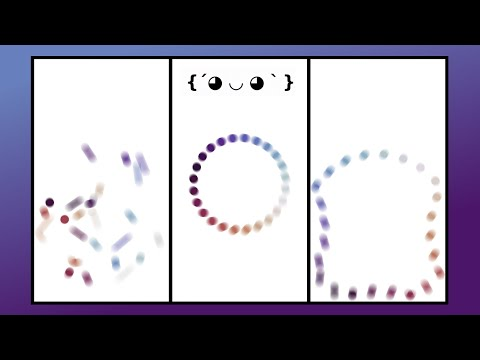

In [6]:
YouTubeVideo('d7UpLz27Q9Y', width=300, height=500)

In [7]:
def initialize():
    width, height = 16, 9
    e = 0.90 # Elasticity of objects.  Must be <=1.  Values closer to 1 mean the bounces do not lose much energy.
    space = setup_space(width, height, e)
    
    # Create a circle with radius R, composed of N balls with radius r
    N, R, r = 24, 2.5, 0.2
    # center of the circle
    cx, cy = width / 2, height / 2
    # velocity of each ball in the tangential direction
    vt = 3.0
    
    balls = []
    np.random.seed(0)
    for t in np.linspace(0, 2 * np.pi, N, endpoint=False):
        balls.append(mk_ball(
            x = cx + R*np.cos(t),
            y = cy + R*np.sin(t),
            vx = vt*np.cos(t+np.pi/2), 
            vy = vt*np.sin(t+np.pi/2),
            radius = r, 
            e = e, 
            space = space))
                     
    return width, height, space, balls

# Step 4: Actually run the simulations!

In [8]:
T = 4 # how long to simulate?
dt = 1/300 # we simulate 300 timesteps per second

# Forward simulation
width, height, space, balls = initialize()
f_ts, f_positions = sim(
    space, balls, T, dt, height
)

# Backward simulation
width, height, space, balls = initialize()
# To simulate backwards, we invert the initial velocity of each ball
# and set the elasticity of each object to the reciprocal of the true value
for b in balls:
    s = list(b.shapes)[0]
    s.elasticity = 1 / s.elasticity
    b.velocity = -1 * b.velocity
for s in space.static_body.shapes:
    s.elasticity = 1 / s.elasticity    
b_ts, b_positions = sim(
    space, balls, T, dt, height
)

# Stitch the resulting trajectories together
ts = list(-1 * b_ts[-1:0:-1]) + list(f_ts)
positions = b_positions[-1:0:-1] + f_positions    

100%|████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 4940.28it/s]


## Step 5: render, display and (optionally) save.

In [9]:
subsampling = 10 # render one out of this number of timesteps.
# Since we have 300 timesteps per second, 10 yields 30 fps. 5 yields 60 fps.

dpi = 30 # use low values for preview. dpi=120 yields fullhd video if width,height are 16,9

# Prepare the figure and axes
fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
ax.set(xlim=[0, width], ylim=[0, height])
ax.set_aspect("equal")
ax.set_position([0, 0, 1, 1])
fig.set(facecolor="y")

# Prepare the patches for the balls
cmap = plt.get_cmap("twilight")
circles = [plt.Circle((0, 0), radius=b.radius, facecolor=cmap(i/len(balls))) for i,b in enumerate(balls)]
[ax.add_patch(c) for c in circles]

# Draw the walls as black lines
for s in space.static_body.shapes:
    ax.plot([s.a.x, s.b.x], [s.a.y, s.b.y], linewidth=2, color="k")

# animation function. This is called sequentially
def drawframe(p):
    for i, c in enumerate(circles):
        c.set_center(p[i])
    return circles

anim = animation.FuncAnimation(
    fig,
    drawframe,
    frames=positions[::subsampling],
    interval=dt * subsampling * 1000,
    blit=True,
)

plt.close(fig)
print(f"Rendering {len(positions[::subsampling])} frames at {1/(dt * subsampling)} fps")
HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())

Rendering 240 frames at 30.0 fps


In [10]:
# Run this cell to save the animation to file
save = False
if save:
    FFwriter = animation.FFMpegWriter(fps = 1/(dt * subsampling))
    anim.save(
        "file.mp4",
        writer=FFwriter,
    )
    plt.close(fig)

## What next?

### 1: play with `initialize()`
The most obvious (and fun) tweak is to play with the initialize function.  Create other configurations of balls, such as the grids or towers shown in the video below!

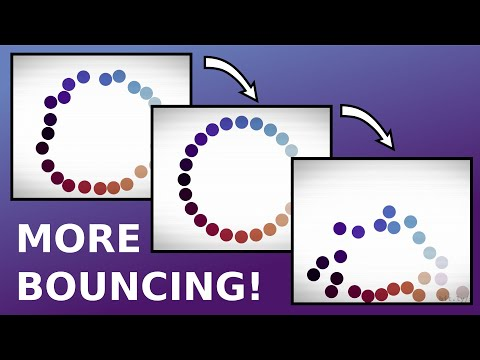

In [11]:
YouTubeVideo('HMT14M4x3QE', listType="playlist", list="PL70Kxx3q2LQR8LEJVzP92HAQNupPKBlEX", width=600, height=338)

## 2: improve quality
To render higher-resolution video, increase DPI in the rendering cell

To render higher-fps video, decrease subsampling in the rendering cell